<a href="https://colab.research.google.com/github/valeromora/TAM_2025-1/blob/main/Parcial1/Parcial1_punto2_IsabellaValero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.6 MB/s eta 0:00:00


In [6]:
#cargar datos desde drive acceso libre
#https://drive.google.com/file/d/1hW3JT6TnBFSm8Gp4Z0U_WZ5t0dSNudb9/view?usp=sharing

from google.colab import drive
drive.mount('/content/drive')
!unzip -o "/content/drive/My Drive/archive.zip"

Mounted at /content/drive
Archive:  /content/drive/My Drive/archive.zip
  inflating: AmesHousing.csv         


# Lectura de la base de datos

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = '/content/AmesHousing.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv
Xdata.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


#Exploración
Se obtiene información acerca del dataset obteniendo los tipos de variables y el conteo de no-nulos

In [8]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

Hay varias caracteristicas que tienen muchos valores nulos, entonces se hace un umbral (del 65%) para descartar las que tienen un porcentaje de valores nulos superior al umbral.

In [9]:
threshold = 0.65

missing_percentages = Xdata.isnull().sum() / len(Xdata) # Calculate the percentage of missing values for each column
columns_to_drop = missing_percentages[missing_percentages > threshold].index
Xdata = Xdata.drop(columns=columns_to_drop)

print(f"Columns dropped due to more than {threshold*100}% missing values:\n{columns_to_drop}") # Now 'data' contains only the columns where missing values percentage is less than or equal to 65%.

Columns dropped due to more than 65.0% missing values:
Index(['Alley', 'Pool QC', 'Fence', 'Misc Feature'], dtype='object')


In [10]:
Xdata.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [11]:
Xdata["SalePrice"].describe()

,SalePrice
count,2930.000000
mean,180796.060068
std,79886.692357
min,12789.000000
25%,129500.000000
50%,160000.000000
75%,213500.000000
max,755000.000000


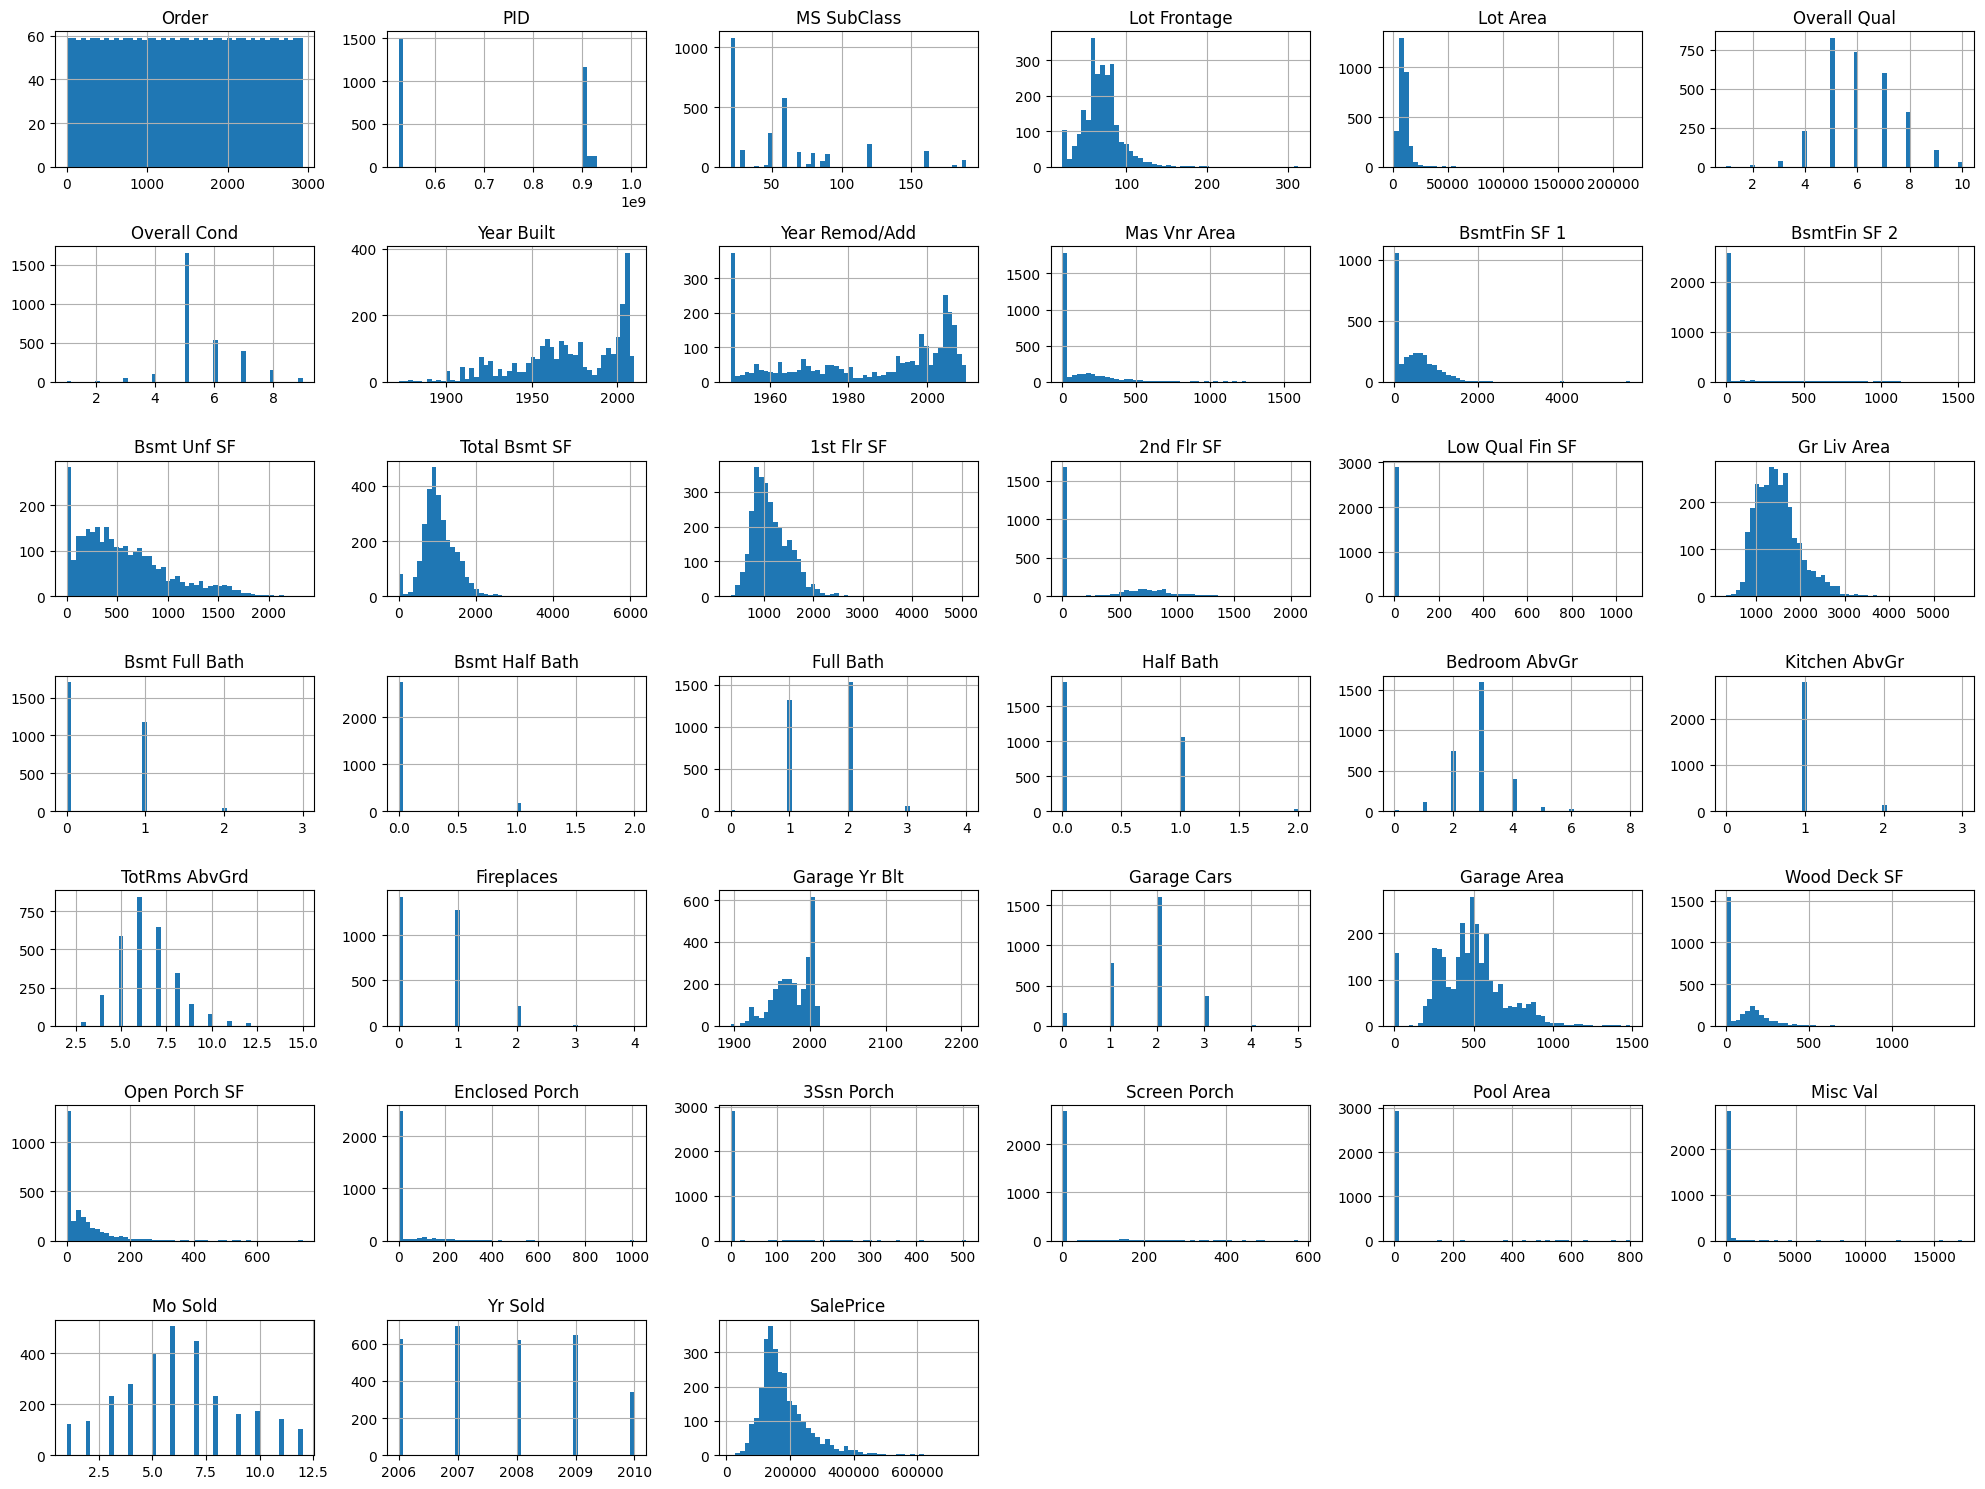

In [12]:
#import os
#try:
#  os.mkdir('results')
#except:
#  print("Carpeta results ya existe")

Xdata.hist(bins=50, figsize=(20,15))
plt.tight_layout()
#plt.savefig('results/attribute_histogram_plots.pdf', format='pdf', dpi=300)#para grabar resultados en pdf
plt.show()

#Procesamiento datos
Para este proceso se utilizó una referencia: https://www.kaggle.com/code/junaiddata35/ames-housing-dataset-house-price-prediction

Lo primero es rellenar los datos faltantes de las columnas, si son númericas con la mediana y si son categoricas con la moda.

In [13]:
# Numerical columns ke liye missing values fill karna
# Rellenar valores faltantes en columnas numéricas
numerical_cols = Xdata.select_dtypes(include=np.number).columns
for col in numerical_cols:
  if Xdata[col].isnull().any():
    Xdata[col] = Xdata[col].fillna(Xdata[col].median())

# Categorical columns ke liye missing values fill karna
# Completar valores faltantes para columnas categóricas
categorical_cols = Xdata.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
  if Xdata[col].isnull().any():
    Xdata[col] = Xdata[col].fillna(Xdata[col].mode()[0])

Como las columnas categoricas deben ser tratadas primero se hace una identificación de éstas para saber qué conversión aplicarles.

In [14]:
categorical_cols = Xdata.select_dtypes(include='object').columns

# Crear diccionario con los valores únicos de cada columna categórica
unique_values_dict = {}

for col in categorical_cols:
    unique_vals = Xdata[col].dropna().unique().tolist()
    unique_values_dict[col] = unique_vals
    print(f"\n--- {col} ---")
    print(Xdata[col].value_counts())
    print(f"Unique values: {Xdata[col].nunique()}")


--- MS Zoning ---
MS Zoning
RL         2273
RM          462
FV          139
RH           27
C (all)      25
I (all)       2
A (agr)       2
Name: count, dtype: int64
Unique values: 7

--- Street ---
Street
Pave    2918
Grvl      12
Name: count, dtype: int64
Unique values: 2

--- Lot Shape ---
Lot Shape
Reg    1859
IR1     979
IR2      76
IR3      16
Name: count, dtype: int64
Unique values: 4

--- Land Contour ---
Land Contour
Lvl    2633
HLS     120
Bnk     117
Low      60
Name: count, dtype: int64
Unique values: 4

--- Utilities ---
Utilities
AllPub    2927
NoSewr       2
NoSeWa       1
Name: count, dtype: int64
Unique values: 3

--- Lot Config ---
Lot Config
Inside     2140
Corner      511
CulDSac     180
FR2          85
FR3          14
Name: count, dtype: int64
Unique values: 5

--- Land Slope ---
Land Slope
Gtl    2789
Mod     125
Sev      16
Name: count, dtype: int64
Unique values: 3

--- Neighborhood ---
Neighborhood
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
So

Quitando la salida que es SalePrice, se identifican las columnas categoricas y se establece que para las que tengan solo dos valores únicos se hace una one hot encoding. Si tienen más valores únicos se aplica una ordinal encoding, el cuál se calcula el orden según el promedio de SalePrice con cada valor único.

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

import pandas as pd
import numpy as np

# Xdata contiene las features y ydata es SalePrice
X_encoded = Xdata.copy()
ydata = Xdata['SalePrice']
y = ydata.copy()

# Identificar columnas categóricas
categorical_cols = X_encoded.select_dtypes(exclude=np.number).columns

# Crear una lista para columnas codificadas
one_hot_cols = []
ordinal_cols = []

# Diccionario para el orden de las columnas ordinales
ordinal_mapping = {}

for col in categorical_cols:
    unique_vals = X_encoded[col].nunique()
    if unique_vals == 2:
        one_hot_cols.append(col)
    else:
        ordinal_cols.append(col)

        # Calcular el orden según el promedio de SalePrice
        order = (
            pd.concat([X_encoded[col], y], axis=1)
            .groupby(col)['SalePrice']
            .mean()
            .sort_values()
            .index
            .tolist()
        )
        ordinal_mapping[col] = order

# Aplicar One-Hot Encoding
X_encoded = pd.get_dummies(X_encoded, columns=one_hot_cols, drop_first=True)
# Convertir todas las columnas booleanas en X_encoded a enteros (0 o 1)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Aplicar Ordinal Encoding según el orden aprendido
for col in ordinal_cols:
    order = ordinal_mapping[col]
    # Crear un mapeo explícito a valores numéricos
    map_dict = {val: idx for idx, val in enumerate(order)}
    X_encoded[col] = X_encoded[col].map(map_dict)


In [16]:
X_encoded.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,Street_Pave,Central Air_Y
0,1,526301100,20,5,141.0,31770,1,1,2,2,...,0,0,0,5,2010,5,4,215000,1,1
1,2,526350040,20,4,80.0,11622,0,1,2,1,...,120,0,0,6,2010,5,4,105000,1,1
2,3,526351010,20,5,81.0,14267,1,1,2,2,...,0,0,12500,6,2010,5,4,172000,1,1
3,4,526353030,20,5,93.0,11160,0,1,2,2,...,0,0,0,4,2010,5,4,244000,1,1
4,5,527105010,60,5,74.0,13830,1,1,2,1,...,0,0,0,3,2010,5,4,189900,1,1


Se verifican los tipos de datos

In [17]:
print("Forma del DataFrame codificado:", X_encoded.shape)
print("\nTipos de datos por columna:")
print(X_encoded.dtypes.value_counts())

Forma del DataFrame codificado: (2930, 78)

Tipos de datos por columna:
int64      67
float64    11
Name: count, dtype: int64


In [18]:
# Ver algunas columnas ordinales codificadas
print("\n--- Muestra de columnas ordinales codificadas ---")
print(X_encoded[ordinal_cols].head())


--- Muestra de columnas ordinales codificadas ---
   MS Zoning  Lot Shape  Land Contour  Utilities  Lot Config  Land Slope  \
0          5          1             1          2           2           0   
1          4          0             1          2           1           0   
2          5          1             1          2           2           0   
3          5          0             1          2           2           0   
4          5          1             1          2           1           0   

   Neighborhood  Condition 1  Condition 2  Bldg Type  ...  Kitchen Qual  \
0            11            5            4          3  ...             2   
1            11            3            4          3  ...             2   
2            11            5            4          3  ...             3   
3            11            5            4          3  ...             4   
4            15            5            4          3  ...             2   

   Functional  Fireplace Qu  Garage Type 

In [19]:
# Ver columnas con One-Hot
print("\n--- Muestra de columnas One-Hot codificadas ---")
one_hot_generated_cols = [col for col in X_encoded.columns if any(prefix in col for prefix in one_hot_cols)]
print(X_encoded[one_hot_generated_cols].head())


--- Muestra de columnas One-Hot codificadas ---
   Street_Pave  Central Air_Y
0            1              1
1            1              1
2            1              1
3            1              1
4            1              1


También se puede reducir el dataset descartando variales cuya correlación con la variable objetivo las hace irrelevantes

In [20]:
correlations = X_encoded.corr()
target_corr = correlations["SalePrice"].drop("SalePrice")

In [21]:
# Umbral de significancia
threshold = 0.2 #pensando en percentiles

# Variables con correlación fuerte (positiva o negativa)
relevant_features = target_corr[abs(target_corr) > threshold].index.tolist() #se usa valor absoluto aqui para considerar las correlaciones negativas

print("Variables relevantes (correlación > 0.25):")
print(relevant_features)

Variables relevantes (correlación > 0.25):
['PID', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Lot Shape', 'Land Contour', 'Neighborhood', 'House Style', 'Overall Qual', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Foundation', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'Total Bsmt SF', 'Heating QC', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Full Bath', 'Half Bath', 'Kitchen Qual', 'TotRms AbvGrd', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Paved Drive', 'Wood Deck SF', 'Open Porch SF', 'Sale Type', 'Sale Condition', 'Central Air_Y']


Hay muchas que no son tan relevantes entonces solo se conservan las relevantes

In [22]:
# Filtrar solo variables relevantes
X_filtered = X_encoded[relevant_features]

In [23]:
print("\nForma del nuevo conjunto de datos filtrado:", X_filtered.shape)
print("\nVista previa:")
print(X_filtered.head())


Forma del nuevo conjunto de datos filtrado: (2930, 46)

Vista previa:
         PID  MS Zoning  Lot Frontage  Lot Area  Lot Shape  Land Contour  \
0  526301100          5         141.0     31770          1             1   
1  526350040          4          80.0     11622          0             1   
2  526351010          5          81.0     14267          1             1   
3  526353030          5          93.0     11160          0             1   
4  527105010          5          74.0     13830          1             1   

   Neighborhood  House Style  Overall Qual  Year Built  ...  Garage Yr Blt  \
0            11            5             6        1960  ...         1960.0   
1            11            5             5        1961  ...         1961.0   
2            11            5             6        1958  ...         1958.0   
3            11            5             7        1968  ...         1968.0   
4            15            6             5        1997  ...         1997.0   

   

#Graficos para el dashboard

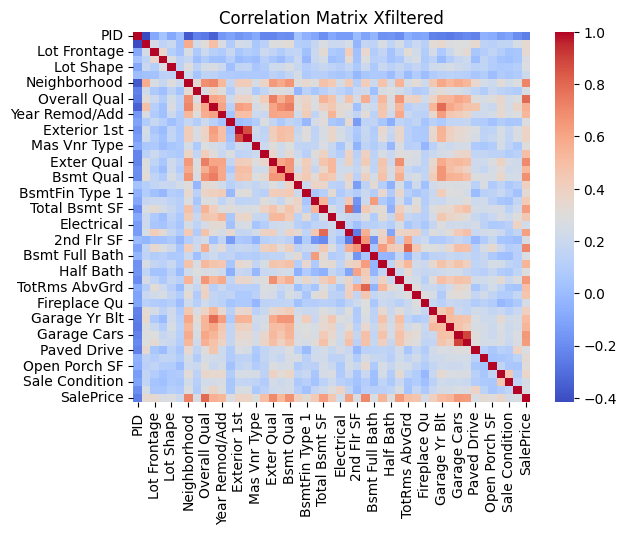

In [74]:
# Correlation matrix
import seaborn as sns
# Select only numerical features for correlation analysis
#numerical_data = Xdata.select_dtypes(include=['number'])
sns.heatmap(X_filtered.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix Xfiltered")
plt.savefig('heatmap_correlation_matrix.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

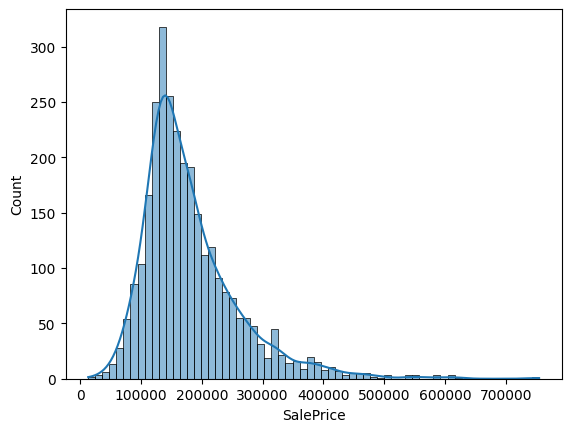

In [72]:
sns.histplot(data=Xdata, x="SalePrice", kde=True)
plt.savefig('correlation_matrix_Xfiltered.png', format='png', dpi=300)

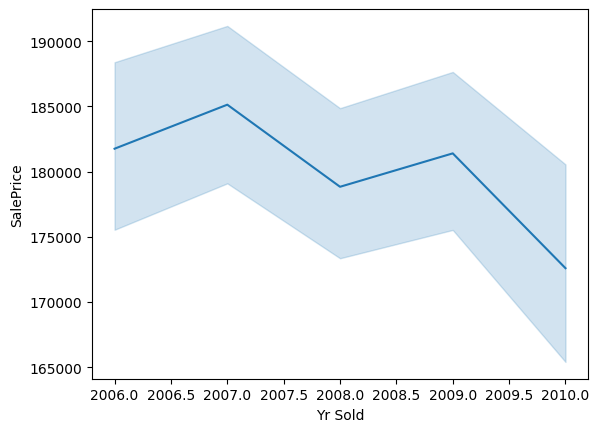

In [82]:
sns.lineplot(data=Xdata, x="Yr Sold", y="SalePrice")
plt.savefig('yr_sold_vs_price.png', format='png', dpi=300)

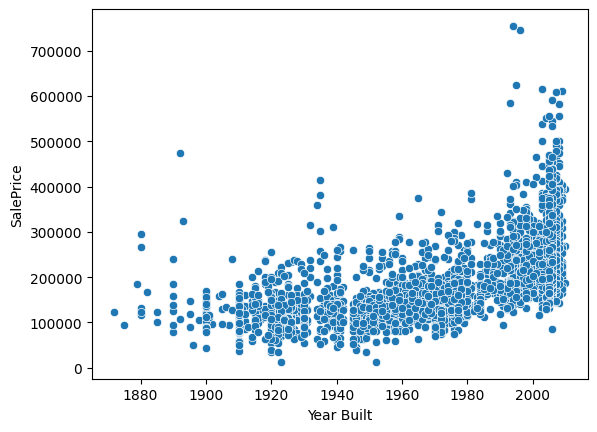

In [83]:
sns.scatterplot(data=Xdata, x="Year Built", y="SalePrice")
plt.savefig('yr_built_vs_price.png', format='png', dpi=300)

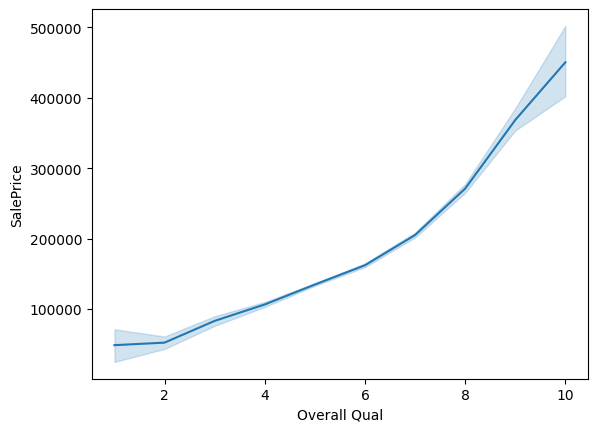

In [84]:
sns.lineplot(data=Xdata, x="Overall Qual", y="SalePrice")
plt.savefig('overall_qual_vs_price.png', format='png', dpi=300)

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación con SalePrice (en el dataset codificado)
correlation = X_filtered.corr()["SalePrice"].sort_values(ascending=False)

# Tomar las 5 más correlacionadas (excluyendo SalePrice)
top_features = correlation.index[1:6]

# Graficar cada una
for feature in top_features:
    plt.figure(figsize=(6, 4))

    # Verificar si la variable era categórica en el dataset original
    if feature in Xdata.columns and Xdata[feature].dtype == 'object':
        # Usar variable original categórica y boxplot
        sns.boxplot(x=Xdata[feature], y=Xdata["SalePrice"])
        plt.xticks(rotation=45)
    else:
        # Usar scatterplot si es numérica
        sns.scatterplot(x=X_filtered[feature], y=X_filtered["SalePrice"])

    plt.title(f"{feature} vs SalePrice")
    plt.tight_layout()
    plt.savefig(f"{feature}_vs_SalePrice.png", bbox_inches='tight')
    plt.close()

#Normalización

In [25]:
from sklearn.preprocessing import StandardScaler
#Normalización
scaler = StandardScaler()
X_filtered["SalePrice"] = y.values  # Añadir la columna de nuevo antes de escalar

# Detectar columnas binarias (one-hot encoded)
onehot_cols = X_filtered.nunique()[X_filtered.nunique() == 2].index.tolist()

# Columnas numéricas (todas las demás menos las one-hot)
num_cols = X_filtered.columns.difference(onehot_cols)

# Separar
X_num = X_filtered[num_cols]
X_onehot = X_filtered[onehot_cols]

X_pre_sca = pd.DataFrame(scaler.fit_transform(X_num), columns=num_cols, index=X_num.index)

X_scaled = pd.concat([X_pre_sca, X_onehot], axis=1)

# Partición entrenamiento y evaluación

In [26]:
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(X_pre_sca,test_size=0.3)
col_sal = "SalePrice"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)

In [27]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(2051,) (879,)


Medidas de desempeño

In [28]:
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

scoring = {
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'R2': make_scorer(r2_score),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

#Linar Regression

El modelo de regresión lineal **no posee hiperparámetros ajustables** que modifiquen su complejidad o la función de pérdida, ya que simplemente estima los coeficientes que minimizan el error cuadrático medio mediante una **solución analítica cerrada**. Por esta razón:

- **No se aplica búsqueda de hiperparámetros.**
- Se realiza únicamente **validación cruzada simple** para evaluar su rendimiento.
- Se utiliza como **línea base** para comparar modelos más complejos con regularización o kernels.
- Su simplicidad permite interpretar fácilmente la relación entre las variables independientes y la variable dependiente, siendo útil para análisis exploratorio y explicabilidad.

Este modelo ayuda a establecer un punto de referencia mínimo que los modelos más sofisticados deberían superar.


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lr_model = LinearRegression()

# Validación cruzada con 5 folds
cv_results_lr = cross_validate(
    lr_model,
    Xtrain,
    ytrain,
    cv=5,
    scoring=scoring,
    return_train_score=False
)

# Mostrar resultados promedio y desviación estándar
#for metric in scoring.keys():
#    scores = cv_results_lr[f'test_{metric}']
#    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

lr_model.fit(Xtrain, ytrain)
y_pred_lr = lr_model.predict(Xtest)

# Calcular métricas
mae = mean_absolute_error(ytest, y_pred_lr)
mse = mean_squared_error(ytest, y_pred_lr)
r2 = r2_score(ytest, y_pred_lr)
mape = mean_absolute_percentage_error(ytest, y_pred_lr)

results_lr = [{
    "model": "Linear Regression",
    "mae": mae,
    "mse": mse,
    "r2": r2,
    "mape": mape,
    "best_params": "N/A",  # No hay hiperparámetros
    "y_true": ytest,
    "y_pred": y_pred_lr
}]

print("Evaluación en test set:")
print("MAE:", mae)
print("MSE:", mse)
print("R2:", r2)
print("MAPE:", mape)

Evaluación en test set:
MAE: 0.2393969054174094
MSE: 0.1617464649871264
R2: 0.8346879982258432
MAPE: 1.455149354102931


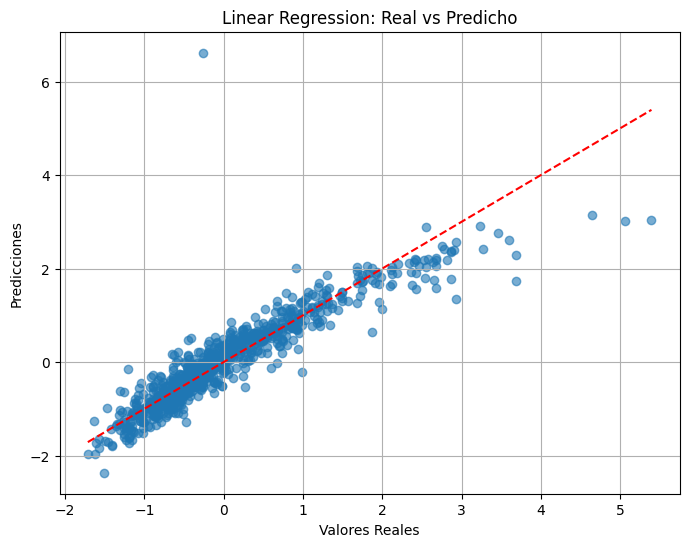

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(ytest, y_pred_lr, alpha=0.6)
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Linear Regression: Real vs Predicho')
plt.grid(True)
plt.show()

Función para evaluar los modelos

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def evaluate_model(name, search, Xtrain, ytrain, Xtest, ytest):
    # Solo entrenar si no fue entrenado
    if not hasattr(search, "best_estimator_"):
        search.fit(Xtrain, ytrain)
    best_model = search.best_estimator_
    y_pred = best_model.predict(Xtest)

    mae = mean_absolute_error(ytest, y_pred)
    mse = mean_squared_error(ytest, y_pred)
    r2 = r2_score(ytest, y_pred)
    mape = mean_absolute_percentage_error(ytest, y_pred)

    print(f" {name} Results:")
    print(f"Best Parameters: {search.best_params_}")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R2: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print("="*40)

    return {
        "name": name,
        "mae": mae,
        "mse": mse,
        "r2": r2,
        "mape": mape,
        "best_params": search.best_params_,
        "y_true": ytest,
        "y_pred": y_pred
    }


#Lasso

## Selección de hiperparámetros

**GridSearchCV** (`param_grid`)  

- **alpha:** `np.logspace(-4, 1, 10)`  
  Se exploran 10 valores de `alpha` en escala logarítmica entre `0.0001` y `10`.  
  Esto es adecuado para regularización en Lasso porque:
  - Valores pequeños → sub-regularización (*overfitting*),
  - Valores grandes → sobre-penalización (*underfitting*).  
  La escala logarítmica captura tanto valores extremos bajos como altos, que son típicos en regularización L1.



**RandomizedSearchCV** (`param_distributions`)  

- **alpha:** `uniform(loc=0.0001, scale=10)`  
  Se generan valores aleatorios entre `0.0001` y aproximadamente `10`.  
  Aunque no es una búsqueda exhaustiva como GridSearch, con `n_iter=30` se logra un buen balance entre:
  - Diversidad en la exploración del espacio de hiperparámetros,
  - Reducción del costo computacional.  
  Es útil cuando se sospecha que puede haber múltiples zonas prometedoras en el espacio de búsqueda.



**BayesSearchCV** (`param_space`)  

- **alpha:** `Real(1e-4, 10, prior='log-uniform')`  
  Utiliza una distribución log-uniforme para explorar valores entre `0.0001` y `10`,  
  lo cual es ideal para Lasso debido a que:
  - Pequeñas variaciones en `alpha` pueden tener gran impacto,
  - Es un espacio continuo y altamente sensible.  
  La búsqueda bayesiana adapta su exploración según el rendimiento observado, haciendo más eficiente la búsqueda del mejor valor.


In [32]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from skopt import BayesSearchCV
from skopt.space import Real


param_grid = {
    "alpha": np.logspace(-4, 1, 10)  # de 1e-4 a 10 en escala logarítmica
}

grid_lasso = GridSearchCV(
    estimator=Lasso(max_iter=10000),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

param_dist = {
    "alpha": uniform(loc=0.0001, scale=10)  # valores aleatorios entre 0.0001 y ~10
}

random_lasso = RandomizedSearchCV(
    estimator=Lasso(max_iter=10000),
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

param_space = {
    'alpha': Real(1e-4, 10, prior='log-uniform')
}

bayes_lasso = BayesSearchCV(
    estimator=Lasso(max_iter=10000),
    search_spaces=param_space,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [33]:
results_lasso = []
results_lasso.append(evaluate_model("Lasso - GridSearch", grid_lasso, Xtrain, ytrain, Xtest, ytest))
results_lasso.append(evaluate_model("Lasso - RandomSearch", random_lasso, Xtrain, ytrain, Xtest, ytest))
results_lasso.append(evaluate_model("Lasso - BayesSearch", bayes_lasso, Xtrain, ytrain, Xtest, ytest))


 Lasso - GridSearch Results:
Best Parameters: {'alpha': np.float64(0.004641588833612782)}
MAE: 0.2377
MSE: 0.1589
R2: 0.8376
MAPE: 1.4806
 Lasso - RandomSearch Results:
Best Parameters: {'alpha': np.float64(0.20594494295802446)}
MAE: 0.3138
MSE: 0.2472
R2: 0.7473
MAPE: 1.5859
 Lasso - BayesSearch Results:
Best Parameters: OrderedDict([('alpha', 0.00541573148226654)])
MAE: 0.2377
MSE: 0.1589
R2: 0.8376
MAPE: 1.4843


#ElasticNet

## Selección de hiperparámetros

**GridSearchCV** (`param_grid_elastic`)  

- **alpha:** `np.logspace(-4, 1, 10)`  
  Se exploran valores desde `0.0001` hasta `10` en escala logarítmica, lo que cubre desde regularización muy baja (posible *overfitting*) hasta muy alta (*underfitting*).  
  Este rango es común porque el efecto de `alpha` no es lineal y pequeñas variaciones pueden tener gran impacto.

- **l1_ratio:** `np.linspace(0, 1, 5)`  
  Se prueban cinco valores equidistantes entre:
  - `0`: pura regularización L2 (*Ridge*),
  - `1`: pura regularización L1 (*Lasso*).  
  ElasticNet combina ambas, por lo que esta mezcla permite encontrar un equilibrio entre:
  - Selección de variables (L1),
  - Estabilidad del modelo (L2).



**RandomizedSearchCV** (`param_dist_elastic`)  

- **alpha:** `uniform(loc=1e-4, scale=10)`  
  Genera valores aleatorios entre `0.0001` y `10`, cubriendo el mismo rango que `GridSearch`, pero de forma no determinista.  
  Esto puede reducir el tiempo de cómputo y aún así descubrir combinaciones útiles.

- **l1_ratio:** `uniform(loc=0, scale=1)`  
  Explora aleatoriamente cualquier valor entre `0` y `1`,  
  ofreciendo más libertad para encontrar el mejor balance entre regularización L1 y L2.



**BayesSearchCV** (`param_space_elastic`)  

- **alpha:** `Real(1e-4, 10, prior='log-uniform')`  
  El prior log-uniforme permite enfocar la búsqueda en valores pequeños,  
  donde pequeñas variaciones pueden impactar mucho en el rendimiento del modelo.

- **l1_ratio:** `Real(0, 1)`  
  Considera todo el intervalo continuo `[0, 1]`,  
  brindando máxima flexibilidad para combinar L1 y L2.  
  La búsqueda bayesiana usa los resultados anteriores para enfocarse en regiones prometedoras, acelerando la convergencia.


In [34]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real
from scipy.stats import uniform

# ----- GridSearch -----
param_grid_elastic = {
    "alpha": np.logspace(-4, 1, 10),
    "l1_ratio": np.linspace(0, 1, 5)  # combinación entre L1 y L2 (np.linspace(0, 1, 10))
}

grid_elastic = GridSearchCV(
    estimator=ElasticNet(max_iter=10000),
    param_grid=param_grid_elastic,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ----- RandomizedSearch -----
param_dist_elastic = {
    "alpha": uniform(loc=1e-4, scale=10),
    "l1_ratio": uniform(loc=0, scale=1)
}

random_elastic = RandomizedSearchCV(
    estimator=ElasticNet(max_iter=10000),
    param_distributions=param_dist_elastic,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# ----- BayesSearch -----
param_space_elastic = {
    "alpha": Real(1e-4, 10, prior='log-uniform'),
    "l1_ratio": Real(0, 1)
}

bayes_elastic = BayesSearchCV(
    estimator=ElasticNet(max_iter=10000),
    search_spaces=param_space_elastic,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [35]:
# ----- Evaluación -----
results_elasticnet = []
results_elasticnet.append(evaluate_model("ElasticNet - GridSearch", grid_elastic, Xtrain, ytrain, Xtest, ytest))
results_elasticnet.append(evaluate_model("ElasticNet - RandomSearch", random_elastic, Xtrain, ytrain, Xtest, ytest))
results_elasticnet.append(evaluate_model("ElasticNet - BayesSearch", bayes_elastic, Xtrain, ytrain, Xtest, ytest))


 ElasticNet - GridSearch Results:
Best Parameters: {'alpha': np.float64(0.016681005372000592), 'l1_ratio': np.float64(0.25)}
MAE: 0.2374
MSE: 0.1591
R2: 0.8374
MAPE: 1.4710
 ElasticNet - RandomSearch Results:
Best Parameters: {'alpha': np.float64(0.45237288910538065), 'l1_ratio': np.float64(0.32533033076326434)}
MAE: 0.2900
MSE: 0.2198
R2: 0.7753
MAPE: 1.5103
 ElasticNet - BayesSearch Results:
Best Parameters: OrderedDict([('alpha', 0.013558830091749442), ('l1_ratio', 0.2960784002575544)])
MAE: 0.2375
MSE: 0.1591
R2: 0.8374
MAPE: 1.4719


#KernelRidge

## Selección de hiperparámetros

**GridSearchCV** (`param_grid_kr`)  
Se definen tres bloques para explorar hiperparámetros según el tipo de kernel:

- **alpha:** `np.logspace(-4, 1, 10)`  
  Controla la regularización. Usar una escala logarítmica permite evaluar tanto regularización débil como fuerte,  
  lo cual es esencial porque `alpha` afecta directamente el equilibrio sesgo-varianza del modelo.

- **kernel:** `["linear"]`, `["rbf"]`, `["poly"]`  
  Diferentes kernels capturan distintas relaciones:
  - `linear`: Para relaciones lineales.
  - `rbf`: Para relaciones no lineales suaves.
  - `poly`: Para relaciones polinomiales.  
  Evaluar todos permite seleccionar el más adecuado al problema.

- **gamma:** `np.logspace(-4, 1, 5)`  
  Para `rbf` y `poly`, `gamma` controla la complejidad del modelo.  
  Una escala logarítmica permite ajustar desde kernels muy suaves hasta muy complejos.

- **degree:** `[2, 3, 4]`  
  Para `poly`, define el grado del polinomio.  
  Grados bajos son comunes en la práctica y ayudan a evitar el sobreajuste.



**RandomizedSearchCV** (`param_dist_kr`)  

- **alpha:** `uniform(1e-4, 10)`  
  Explora aleatoriamente valores entre `0.0001` y `10`.  
  Útil para descubrir buenas regiones del espacio sin evaluar todas las combinaciones posibles.

- **kernel:** `Categorical(["linear", "rbf", "poly"])`  
  Permite muestrear aleatoriamente entre los distintos tipos de kernel,  
  reduciendo el costo computacional comparado con una búsqueda exhaustiva.

- **gamma:** `uniform(1e-4, 10)`  
  Se exploran valores en un rango amplio para adaptarse a diferentes escalas de datos y niveles de complejidad.

- **degree:** `randint(2, 5)`  
  Prueba de forma aleatoria grados polinomiales entre 2 y 4 (inclusive),  
  cubriendo los valores más útiles en la práctica para evitar el sobreajuste.



**BayesSearchCV** (`param_space_kr`)  

- **alpha:** `Real(1e-4, 10, prior="log-uniform")`  
  Se priorizan valores pequeños mediante escala log-uniforme,  
  ya que pequeñas variaciones pueden tener gran impacto en el rendimiento del modelo.

- **kernel:** `Categorical(["linear", "rbf", "poly"])`  
  La búsqueda bayesiana selecciona de forma adaptativa el mejor kernel según el rendimiento observado.

- **gamma:** `Real(1e-4, 10, prior="log-uniform")`  
  Al igual que `alpha`, usar una distribución log-uniforme mejora la eficiencia en espacios sensibles.  
  `gamma` tiene gran impacto en kernels no lineales, y la búsqueda adaptativa es clave.

- **degree:** `Integer(2, 4)`  
  Se exploran los grados más comunes del kernel polinomial,  
  restringiendo el espacio para evitar complejidad innecesaria sin dejar de cubrir casos útiles.


In [36]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import uniform
import numpy as np
from scipy.stats import randint

# --------- GRID SEARCH ---------
param_grid_kr = [
    {"alpha": np.logspace(-4, 1, 10), "kernel": ["linear"]},
    {"alpha": np.logspace(-4, 1, 10), "kernel": ["rbf"], "gamma": np.logspace(-4, 1, 5)},
    {"alpha": np.logspace(-4, 1, 10), "kernel": ["poly"], "gamma": np.logspace(-4, 1, 5), "degree": [2, 3, 4]},
]

grid_kr = GridSearchCV(
    estimator=KernelRidge(),
    param_grid=param_grid_kr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# --------- RANDOMIZED SEARCH ---------
param_dist_kr = {
    "alpha": uniform(1e-4, 10),
    "kernel": Categorical(["linear", "rbf", "poly"]),
    "gamma": uniform(1e-4, 10),
    "degree": randint(2, 5)
}

random_kr = RandomizedSearchCV(
    estimator=KernelRidge(),
    param_distributions=param_dist_kr,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# --------- BAYESIAN SEARCH ---------
param_space_kr = {
    "alpha": Real(1e-4, 10, prior="log-uniform"),
    "kernel": Categorical(["linear", "rbf", "poly"]),
    "gamma": Real(1e-4, 10, prior="log-uniform"),
    "degree": Integer(2, 4)
}

bayes_kr = BayesSearchCV(
    estimator=KernelRidge(),
    search_spaces=param_space_kr,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [37]:
results_kernelridge = []
# ----- Evaluación -----
results_kernelridge.append(evaluate_model("KernelRidge - GridSearch", grid_kr, Xtrain, ytrain, Xtest, ytest))
results_kernelridge.append(evaluate_model("KernelRidge - RandomSearch", random_kr, Xtrain, ytrain, Xtest, ytest))
results_kernelridge.append(evaluate_model("KernelRidge - BayesSearch", bayes_kr, Xtrain, ytrain, Xtest, ytest))

 KernelRidge - GridSearch Results:
Best Parameters: {'alpha': np.float64(0.21544346900318845), 'degree': 4, 'gamma': np.float64(0.0017782794100389228), 'kernel': 'poly'}
MAE: 0.1786
MSE: 0.0757
R2: 0.9227
MAPE: 1.0047
 KernelRidge - RandomSearch Results:
Best Parameters: {'alpha': np.float64(8.324526408004218), 'degree': 3, 'gamma': np.float64(0.007887658410143283), 'kernel': 'poly'}
MAE: 0.1836
MSE: 0.0800
R2: 0.9182
MAPE: 1.0797
 KernelRidge - BayesSearch Results:
Best Parameters: OrderedDict([('alpha', 0.3335805084312365), ('degree', 4), ('gamma', 0.0024550767299563203), ('kernel', 'poly')])
MAE: 0.1767
MSE: 0.0750
R2: 0.9233
MAPE: 0.9873


#SGDRegressor

## Selección de hiperparámetros

**GridSearchCV** (`param_grid_sgd`)  
La búsqueda está dividida en dos bloques, ya que algunos hiperparámetros solo aplican en ciertos casos:

- **alpha:** `np.logspace(-6, -1, 6)`  
  Controla la regularización. Se usa una escala logarítmica para cubrir un rango amplio de niveles de penalización.

- **penalty:** `["l2", "l1", "elasticnet"]`  
  Diferentes regularizadores afectan cómo se reduce la complejidad del modelo.  
  `elasticnet` es una combinación entre `l1` y `l2`.

- **loss:** `["squared_error", "huber", "epsilon_insensitive"]`  
  Se prueban varias funciones de pérdida:
  - `squared_error`: MSE clásico.
  - `huber`: Más robusto frente a *outliers*.
  - `epsilon_insensitive`: Ignora pequeños errores; útil en regresión con márgenes (como SVR).

- **learning_rate:** `["optimal", "adaptive", "constant", "invscaling"]`  
  Determina cómo cambia la tasa de aprendizaje durante el entrenamiento:
  - `optimal`: Depende de `eta0`.
  - `adaptive`: Reduce la tasa si no hay mejoras.
  - `constant`, `invscaling`: Requieren definir `eta0`.

- **eta0:** `[1e-4, 1e-3, 1e-2, 1e-1]`  
  Valor inicial de la tasa de aprendizaje. Solo se utiliza cuando `learning_rate` es `constant` o `invscaling`.



**RandomizedSearchCV** (`param_dist_sgd`)  

- **alpha:** `loguniform(1e-6, 1e-1)`  
  Se usa una distribución log-uniforme para explorar eficientemente valores de regularización.  
  Esto es útil porque el efecto de `alpha` es muy sensible en órdenes de magnitud pequeños.

- **penalty, loss, learning_rate:**  
  Se muestrean aleatoriamente entre las mismas opciones que en `GridSearch`, reduciendo la cantidad total de combinaciones probadas.

- **eta0:** `loguniform(1e-4, 1e-1)`  
  Solo se usa si el tipo de `learning_rate` lo requiere.  
  Este muestreo aleatorio permite capturar buenos valores sin necesidad de probar todos.



**BayesSearchCV** (`param_space_sgd`)  

- **alpha:** `Real(1e-6, 1e-1, prior='log-uniform')`  
  Igual que en `RandomizedSearch`, pero optimizado mediante búsqueda bayesiana adaptativa.

- **penalty, loss, learning_rate:**  
  Tratados como variables **categóricas**, permitiendo a la búsqueda bayesiana seleccionar combinaciones óptimas en función del rendimiento observado.

- **eta0:** `Real(1e-4, 1e-1, prior="log-uniform")`  
  Solo relevante si el `learning_rate` lo requiere.  
  La búsqueda bayesiana ajusta su exploración en torno a valores más prometedores en cada iteración.


In [38]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# ----- GridSearch -----
param_grid_sgd = [
    {
        "alpha": np.logspace(-6, -1, 6),
        "penalty": ["l2", "l1", "elasticnet"],
        "loss": ["squared_error", "huber", "epsilon_insensitive"],
        "learning_rate": ["optimal", "adaptive"]
    },
    {
        "alpha": np.logspace(-6, -1, 6),
        "penalty": ["l2", "l1", "elasticnet"],
        "loss": ["squared_error", "huber", "epsilon_insensitive"],
        "learning_rate": ["constant", "invscaling"],
        "eta0": [1e-4, 1e-3, 1e-2, 1e-1]
    }
]

grid_sgd = GridSearchCV(
    estimator=SGDRegressor(max_iter=1000, tol=1e-3),
    param_grid=param_grid_sgd,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ----- RandomizedSearch -----
param_dist_sgd = {
    "alpha": loguniform(1e-6, 1e-1),
    "penalty": ["l2", "l1", "elasticnet"],
    "loss": ["squared_error", "huber", "epsilon_insensitive"],
    "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
    "eta0": loguniform(1e-4, 1e-1)  # Será ignorado si learning_rate no lo requiere
}

random_sgd = RandomizedSearchCV(
    estimator=SGDRegressor(max_iter=1000, tol=1e-3),
    param_distributions=param_dist_sgd,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# ----- BayesSearch -----
param_space_sgd = {
    "alpha": Real(1e-6, 1e-1, prior='log-uniform'),
    "penalty": Categorical(["l2", "l1", "elasticnet"]),
    "loss": Categorical(["squared_error", "huber", "epsilon_insensitive"]),
    "learning_rate": Categorical(["constant", "optimal", "invscaling", "adaptive"]),
    "eta0": Real(1e-4, 1e-1, prior="log-uniform")  # Igual que arriba
}

bayes_sgd = BayesSearchCV(
    estimator=SGDRegressor(max_iter=1000, tol=1e-3),
    search_spaces=param_space_sgd,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [39]:
results_sgrd = []
# ----- Evaluación -----
results_sgrd.append(evaluate_model("SGDRegressor - GridSearch", grid_sgd, Xtrain, ytrain, Xtest, ytest))
results_sgrd.append(evaluate_model("SGDRegressor - RandomSearch", random_sgd, Xtrain, ytrain, Xtest, ytest))
results_sgrd.append(evaluate_model("SGDRegressor - BayesSearch", bayes_sgd, Xtrain, ytrain, Xtest, ytest))


 SGDRegressor - GridSearch Results:
Best Parameters: {'alpha': np.float64(0.01), 'eta0': 0.001, 'learning_rate': 'constant', 'loss': 'squared_error', 'penalty': 'l1'}
MAE: 0.2352
MSE: 0.1598
R2: 0.8367
MAPE: 1.4550
 SGDRegressor - RandomSearch Results:
Best Parameters: {'alpha': np.float64(3.029476085280708e-05), 'eta0': np.float64(0.0003131849018141121), 'learning_rate': 'constant', 'loss': 'epsilon_insensitive', 'penalty': 'l2'}
MAE: 0.2258
MSE: 0.1658
R2: 0.8305
MAPE: 1.2416
 SGDRegressor - BayesSearch Results:
Best Parameters: OrderedDict([('alpha', 0.00011233621690895234), ('eta0', 0.015246748254295629), ('learning_rate', 'adaptive'), ('loss', 'squared_error'), ('penalty', 'elasticnet')])
MAE: 0.2395
MSE: 0.1620
R2: 0.8345
MAPE: 1.4508


#BayesianRidge

## Selección de hiperparámetros

**GridSearchCV** (`param_grid_bayesridge`)  
Se exploran valores discretos muy pequeños para los hiperparámetros que controlan la precisión de las distribuciones Gamma en la regularización bayesiana:

- **alpha_1, alpha_2:**  
  Parámetros que controlan la precisión de la distribución *a priori* para el término de ruido (error).  
  Valores pequeños (`[1e-6, 1e-5, 1e-4, 1e-3]`) permiten controlar la cantidad de ruido que el modelo asume en los datos.

- **lambda_1, lambda_2:**  
  Parámetros que controlan la precisión *a priori* para los coeficientes (regularización).  
  También se prueban en el mismo rango para ajustar la fuerza de la regularización.

Este enfoque exhaustivo cubre combinaciones fijas para encontrar el mejor ajuste posible dentro de este rango pequeño, típico para regularizaciones bayesianas.



**RandomizedSearchCV** (`param_dist_bayesridge`)  
Permite una búsqueda más flexible y eficiente en espacios continuos:

- **alpha_1, alpha_2, lambda_1, lambda_2:**  
  Usan distribuciones log-uniformes en el rango `[1e-6, 1e-2]`, lo que permite muestrear valores continuos en un rango amplio.  
  Esto es importante porque la influencia de estos hiperparámetros es muy sensible a cambios pequeños en valores bajos.

Los valores se muestrean aleatoriamente para explorar regiones prometedoras del espacio de hiperparámetros sin necesidad de probar todas las combinaciones.



**BayesSearchCV** (`param_space_bayesridge`)  
Optimiza la selección de hiperparámetros usando búsqueda bayesiana:

- **alpha_1, alpha_2, lambda_1, lambda_2:**  
  Espacio continuo definido con distribución log-uniforme, igual que en `RandomizedSearch`.  
  La diferencia es que aquí la búsqueda es *adaptativa*: ajusta dinámicamente qué regiones del espacio explorar según los resultados previos.

Este método es especialmente útil para modelos bayesianos, donde la precisión en la regularización es clave para el rendimiento y el balance entre sesgo y varianza.


In [40]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, loguniform
from skopt import BayesSearchCV
from skopt.space import Real

# ----- GridSearch -----
param_grid_bayesridge = {
    "alpha_1": [1e-6, 1e-5, 1e-4, 1e-3],
    "alpha_2": [1e-6, 1e-5, 1e-4, 1e-3],
    "lambda_1": [1e-6, 1e-5, 1e-4, 1e-3],
    "lambda_2": [1e-6, 1e-5, 1e-4, 1e-3]
}

grid_bayesridge = GridSearchCV(
    estimator=BayesianRidge(),
    param_grid=param_grid_bayesridge,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ----- RandomizedSearch -----
param_dist_bayesridge = {
    "alpha_1": loguniform(1e-6, 1e-2),
    "alpha_2": loguniform(1e-6, 1e-2),
    "lambda_1": loguniform(1e-6, 1e-2),
    "lambda_2": loguniform(1e-6, 1e-2)
}

random_bayesridge = RandomizedSearchCV(
    estimator=BayesianRidge(),
    param_distributions=param_dist_bayesridge,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# ----- BayesSearch -----
param_space_bayesridge = {
    "alpha_1": Real(1e-6, 1e-2, prior='log-uniform'),
    "alpha_2": Real(1e-6, 1e-2, prior='log-uniform'),
    "lambda_1": Real(1e-6, 1e-2, prior='log-uniform'),
    "lambda_2": Real(1e-6, 1e-2, prior='log-uniform')
}

bayes_bayesridge = BayesSearchCV(
    estimator=BayesianRidge(),
    search_spaces=param_space_bayesridge,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)


In [41]:
resuls_br = []
# ----- Evaluación -----
resuls_br.append(evaluate_model("BayesianRidge - GridSearch", grid_bayesridge, Xtrain, ytrain, Xtest, ytest))
resuls_br.append(evaluate_model("BayesianRidge - RandomSearch", random_bayesridge, Xtrain, ytrain, Xtest, ytest))
resuls_br.append(evaluate_model("BayesianRidge - BayesSearch", bayes_bayesridge, Xtrain, ytrain, Xtest, ytest))


 BayesianRidge - GridSearch Results:
Best Parameters: {'alpha_1': 1e-06, 'alpha_2': 0.001, 'lambda_1': 0.001, 'lambda_2': 1e-06}
MAE: 0.2385
MSE: 0.1606
R2: 0.8359
MAPE: 1.4523
 BayesianRidge - RandomSearch Results:
Best Parameters: {'alpha_1': np.float64(1.987021538542864e-06), 'alpha_2': np.float64(0.008862326508576254), 'lambda_1': np.float64(0.001227380098785297), 'lambda_2': np.float64(6.235377135673162e-06)}
MAE: 0.2385
MSE: 0.1606
R2: 0.8359
MAPE: 1.4523
 BayesianRidge - BayesSearch Results:
Best Parameters: OrderedDict([('alpha_1', 0.006712988078968355), ('alpha_2', 3.160312973973525e-06), ('lambda_1', 0.009965720932650484), ('lambda_2', 2.8620778268027817e-06)])
MAE: 0.2385
MSE: 0.1606
R2: 0.8359
MAPE: 1.4523


#GaussianProcessRegressor

## Selección de hiperparámetros

**GridSearchCV** (`param_grid_gp`)  
Se exploran combinaciones fijas de kernels y valores pequeños para el parámetro `alpha` que controla el ruido en las observaciones:

- **kernel:**  
  Tres opciones fijas con kernels compuestos:  
  - `C(1.0) * RBF(length_scale=1.0)`: Kernel RBF con escala de longitud 1.0 y constante 1.0.  
  - `C(1.0) * RBF(length_scale=10.0)`: Igual, pero con escala 10.0 para captar variaciones más suaves.  
  - `C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)`: Combina RBF con un kernel blanco para modelar ruido explícito.

- **alpha:** `[1e-10, 1e-5, 1e-2]`  
  Pequeños valores que actúan como ruido añadido para estabilizar la inversa de la matriz de covarianza y evitar overfitting.

Este enfoque busca el mejor kernel y nivel de ruido dentro de estas combinaciones definidas.



**RandomizedSearchCV** (`param_dist_gp`)  
Permite explorar una gama más amplia de kernels y niveles de ruido:

- **kernel:**  
  Se generan más opciones combinando:  
  - RBF con escalas variadas `[0.1, 1.0, 10.0, 100.0]` para modelar distintas suavidades.  
  - `RBF + WhiteKernel` con combinaciones de escalas `[0.1, 1.0, 10.0]` y niveles de ruido `[1e-2, 1.0]` para modelar ruido más o menos fuerte.

- **alpha:**  
  Se muestrea de forma continua con una distribución log-uniforme entre `[1e-10, 1e-2]`, para buscar valores óptimos en un rango muy amplio y sensible.

Esta búsqueda explora muchas más combinaciones para encontrar un balance óptimo entre ajuste y regularización.



**BayesSearchCV** (`param_space_gp`)  
Explora de forma inteligente combinaciones de kernels y regularización usando optimización bayesiana:

- **kernel_name:**  
  Se define como variable categórica entre etiquetas que representan kernels específicos.  
  Se usa un *wrapper* (`GPRWrapper`) para construir el objeto `kernel` real desde la etiqueta, debido a que `BayesSearchCV` no acepta directamente objetos kernel (no son hashables).

- **alpha:**  
  Espacio continuo con distribución log-uniforme entre `[1e-10, 1e-2]`, igual que en `RandomizedSearch`.

Este método bayesiano explora inteligentemente combinaciones según el rendimiento previo, optimizando la búsqueda en un espacio más flexible y complejo como el de los kernels compuestos.


In [42]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from scipy.stats import loguniform
from sklearn.base import BaseEstimator, RegressorMixin, clone

# ----- GridSearch -----
param_grid_gp = {
    "kernel": [
        C(1.0) * RBF(length_scale=1.0),
        C(1.0) * RBF(length_scale=10.0),
        C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
    ],
    "alpha": [1e-10, 1e-5, 1e-2]
}

grid_gp = GridSearchCV(
    GaussianProcessRegressor(normalize_y=True),
    param_grid=param_grid_gp,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ----- RandomizedSearch -----
param_dist_gp = {
    "kernel": [
        C(1.0) * RBF(length_scale=l) for l in [0.1, 1.0, 10.0, 100.0]
    ] + [
        C(1.0) * RBF(length_scale=l) + WhiteKernel(noise_level=n)
        for l in [0.1, 1.0, 10.0]
        for n in [1e-2, 1.0]
    ],
    "alpha": loguniform(1e-10, 1e-2)
}

random_gp = RandomizedSearchCV(
    GaussianProcessRegressor(normalize_y=True),
    param_distributions=param_dist_gp,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# ----- BayesSearch -----
#BayesSearchCV de skopt no admite objetos no hashables en Categorical, por lo que no se puede pasar directamente kernels como C(1.0) * RBF(...)
kernel_options = {
    "RBF_0.1": lambda: C(1.0) * RBF(length_scale=0.1),
    "RBF_1.0": lambda: C(1.0) * RBF(length_scale=1.0),
    "RBF_10.0": lambda: C(1.0) * RBF(length_scale=10.0),
    "RBF_1.0_White": lambda: C(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0),
    "RBF_10.0_White": lambda: C(1.0) * RBF(length_scale=10.0) + WhiteKernel(noise_level=1.0),
}

class GPRWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, kernel_name="RBF_1.0", alpha=1e-10):
        self.kernel_name = kernel_name
        self.alpha = alpha

    def _get_kernel(self):
        return kernel_options[self.kernel_name]()

    def fit(self, X, y):
        self.model_ = GaussianProcessRegressor(
            kernel=self._get_kernel(), alpha=self.alpha, normalize_y=True
        )
        self.model_.fit(X, y)
        return self

    def predict(self, X):
        return self.model_.predict(X)

param_space_gp = {
    "kernel_name": Categorical(list(kernel_options.keys())),
    "alpha": Real(1e-10, 1e-2, prior='log-uniform')
}

bayes_gp = BayesSearchCV(
    estimator=GPRWrapper(),
    search_spaces=param_space_gp,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [53]:
results_gpr = []
# ----- Evaluación -----
results_gpr.append(evaluate_model("GaussianProcess - GridSearch", grid_gp, Xtrain, ytrain, Xtest, ytest))
results_gpr.append(evaluate_model("GaussianProcess - RandomSearch", random_gp, Xtrain, ytrain, Xtest, ytest))
results_gpr.append(evaluate_model("GaussianProcess - BayesSearch", bayes_gp, Xtrain, ytrain, Xtest, ytest))

 GaussianProcess - GridSearch Results:
Best Parameters: {'alpha': 1e-05, 'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)}
MAE: 0.1824
MSE: 0.0782
R2: 0.9200
MAPE: 0.9514
 GaussianProcess - RandomSearch Results:
Best Parameters: {'alpha': np.float64(9.915644566638397e-08), 'kernel': 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1)}
MAE: 0.1824
MSE: 0.0782
R2: 0.9200
MAPE: 0.9514
 GaussianProcess - BayesSearch Results:
Best Parameters: OrderedDict([('alpha', 1.9091131576909444e-07), ('kernel_name', 'RBF_1.0_White')])
MAE: 0.1824
MSE: 0.0782
R2: 0.9200
MAPE: 0.9514


#RandomForestRegressor

## Selección de hiperparámetros

**GridSearchCV** (`param_grid_rf`)  
Se exploran combinaciones fijas de hiperparámetros clave para controlar la complejidad y el rendimiento del bosque aleatorio:

- **n_estimators:** `[100, 200, 300]`  
  Número de árboles en el bosque. Más árboles suelen mejorar la precisión pero incrementan el tiempo de entrenamiento.

- **max_depth:** `[None, 10, 20, 30]`  
  Profundidad máxima de cada árbol. `None` permite que el árbol crezca hasta pureza total (posible sobreajuste). Valores limitados controlan complejidad y evitan overfitting.

- **min_samples_split:** `[2, 5, 10]`  
  Mínimo número de muestras necesarias para dividir un nodo. Valores más altos previenen divisiones muy específicas, regularizando el modelo.

- **min_samples_leaf:** `[1, 2, 4]`  
  Número mínimo de muestras que debe tener una hoja. Incrementar ayuda a evitar hojas con muy pocos datos, mejora la generalización.

- **max_features:** `["auto", "sqrt", "log2"]`  
  Número de características a considerar al buscar la mejor división en cada nodo:  
  - `"auto"`: usa todas las características.  
  - `"sqrt"`: raíz cuadrada del total (default para regresión).  
  - `"log2"`: logaritmo base 2 del total.



**RandomizedSearchCV** (`param_dist_rf`)  
Se usa muestreo aleatorio para explorar más combinaciones con mayor rango:

- **n_estimators:** `randint(100, 1000)`  
  Número aleatorio de árboles entre 100 y 1000, para evaluar impacto de bosques más grandes.

- **max_depth:** `randint(5, 50)`  
  Profundidades variadas entre 5 y 50 para capturar diferentes niveles de complejidad.

- **min_samples_split:** `randint(2, 20)`  
  Valores variados para evitar divisiones muy específicas o demasiado generales.

- **min_samples_leaf:** `randint(1, 10)`  
  Mínimo tamaño de hoja variable para controlar regularización.

- **max_features:** `["auto", "sqrt", "log2"]`  
  Las mismas opciones categóricas que en GridSearch, muestreadas directamente.

Esta búsqueda permite probar configuraciones más diversas con menor costo computacional que un grid exhaustivo.


**BayesSearchCV** (`param_space_rf`)  
Se exploran espacios de búsqueda continuos y categóricos de forma adaptativa:

- **n_estimators:** `Integer(100, 1000)`  
  Espacio entero continuo para número de árboles, optimizado adaptativamente.

- **max_depth:** `Integer(5, 50)`  
  Profundidad del árbol, optimizada con búsqueda bayesiana para encontrar la mejor complejidad.

- **min_samples_split:** `Integer(2, 20)`  
  Controla la división de nodos, con búsqueda inteligente para balancear sesgo-varianza.

- **min_samples_leaf:** `Integer(1, 10)`  
  Tamaño mínimo de hoja, ajustado para evitar overfitting manteniendo flexibilidad.

- **max_features:** `Categorical([None, "sqrt", "log2"])`  
  Opciones categóricas para número de características usadas, incluyendo `None` que equivale a usar todas.

La búsqueda bayesiana explora estos espacios de forma adaptativa, aprendiendo de iteraciones previas para acelerar la convergencia a la mejor combinación.

In [59]:
from sklearn.ensemble import RandomForestRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from scipy.stats import randint

# ----- GridSearch -----
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["auto", "sqrt", "log2"]
}

grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# ----- RandomizedSearch -----
param_dist_rf = {
    "n_estimators": randint(100, 1000),
    "max_depth": randint(5, 50),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["auto", "sqrt", "log2"]
}

random_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

# ----- BayesSearch -----
param_space_rf = {
    "n_estimators": Integer(100, 1000),
    "max_depth": Integer(5, 50),
    "min_samples_split": Integer(2, 20),
    "min_samples_leaf": Integer(1, 10),
    "max_features": Categorical([None, "sqrt", "log2"])
}

bayes_rf = BayesSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    search_spaces=param_space_rf,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)


In [60]:
results_rforest = []
# ----- Evaluación -----
results_rforest.append(evaluate_model("RandomForest - GridSearch", grid_rf, Xtrain, ytrain, Xtest, ytest))
results_rforest.append(evaluate_model("RandomForest - RandomSearch", random_rf, Xtrain, ytrain, Xtest, ytest))
results_rforest.append(evaluate_model("RandomForest - BayesSearch", bayes_rf, Xtrain, ytrain, Xtest, ytest))

 RandomForest - GridSearch Results:
Best Parameters: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 0.1870
MSE: 0.0906
R2: 0.9074
MAPE: 1.0187
 RandomForest - RandomSearch Results:
Best Parameters: {'max_depth': 33, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 620}
MAE: 0.1883
MSE: 0.0927
R2: 0.9053
MAPE: 1.0440
 RandomForest - BayesSearch Results:
Best Parameters: OrderedDict([('max_depth', 18), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 360)])
MAE: 0.1856
MSE: 0.0886
R2: 0.9094
MAPE: 1.0250


#SVR

## Selección de hiperparámetros:

**GridSearchCV** (`param_grid_svr`)

- **svr__C:** `[0.1, 1, 10, 100]`  
  Se exploran valores fijos que van desde una regularización fuerte (0.1) hasta débil (100). Un valor pequeño de C favorece un modelo más simple y generalizable, mientras que uno grande permite un ajuste más preciso a los datos, pero puede llevar a sobreajuste.

- **svr__epsilon:** `[0.01, 0.1, 0.5]`  
  Valores fijos para el margen de tolerancia. Valores pequeños hacen que el modelo sea sensible a desviaciones muy pequeñas, capturando más detalles pero potencialmente ruidosos; valores mayores permiten ignorar pequeños errores, favoreciendo un modelo más robusto.

- **svr__kernel:** `["linear", "rbf"]`  
  Se prueban dos kernels:  
  - `linear` para modelos lineales simples.  
  - `rbf` para capturar relaciones no lineales entre variables.

- **svr__gamma:** `["scale", "auto"]`  
  Parámetro del kernel `rbf` que controla la influencia de cada punto.  
  - `"scale"` usa \( \frac{1}{n\_features \times \text{varianza de X}} \), es la opción recomendada por defecto.  
  - `"auto"` usa \( \frac{1}{n\_features} \).  
  Se ignora si el kernel es `linear`.


**RandomizedSearchCV** (`param_dist_svr`)

- **svr__C:** `uniform(0.1, 100)`  
  Se toman valores continuos uniformemente distribuidos entre 0.1 y 100, lo que permite explorar una gama más amplia de regularizaciones de forma más eficiente que con valores fijos.

- **svr__epsilon:** `uniform(0.01, 1)`  
  Margen de tolerancia también explorado de forma continua para encontrar el valor óptimo entre 0.01 y 1.

- **svr__kernel:** `["linear", "rbf"]`  
  Los kernels se prueban tal cual.

- **svr__gamma:** `["scale", "auto"]`  
  Se prueba el mismo conjunto que en GridSearch.



**BayesSearchCV** (`param_space_svr`)

- **svr__C:** `Real(0.1, 100.0, prior='log-uniform')`  
  El prior log-uniforme permite que la búsqueda se concentre más eficientemente en valores pequeños y medianos de C, donde el rendimiento del modelo suele ser más sensible a cambios, acelerando la convergencia.

- **svr__epsilon:** `Real(0.01, 1.0, prior='uniform')`  
  Se busca de forma continua en el rango completo entre 0.01 y 1, maximizando la flexibilidad para encontrar el margen de tolerancia ideal.

- **svr__kernel:** `Categorical(["linear", "rbf"])`  
  Se consideran ambos kernels, permitiendo que la optimización elija el mejor tipo de modelo.

- **svr__gamma:** `Categorical(["scale", "auto"])`  
  Opciones para gamma cuando se usa kernel `rbf`, ignorado si kernel es `linear`.


In [62]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from scipy.stats import uniform

# ----- GRID SEARCH -----
param_grid_svr = {
    "svr__C": [0.1, 1, 10, 100],
    "svr__epsilon": [0.01, 0.1, 0.5],
    "svr__kernel": ["linear", "rbf"],
    "svr__gamma": ["scale", "auto"]  # se ignora si kernel = linear
}

grid_svr = GridSearchCV(
    estimator=make_pipeline(StandardScaler(), SVR()),
    param_grid=param_grid_svr,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

# ----- RANDOMIZED SEARCH -----
param_dist_svr = {
    "svr__C": uniform(0.1, 100),
    "svr__epsilon": uniform(0.01, 1),
    "svr__kernel": ["linear", "rbf"],
    "svr__gamma": ["scale", "auto"]  # para rbf
}

random_svr = RandomizedSearchCV(
    estimator=make_pipeline(StandardScaler(), SVR()),
    param_distributions=param_dist_svr,
    n_iter=30,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

# ----- BAYES SEARCH -----
param_space_svr = {
    "svr__C": Real(0.1, 100.0, prior='log-uniform'),
    "svr__epsilon": Real(0.01, 1.0, prior='uniform'),
    "svr__kernel": Categorical(["linear", "rbf"]),
    "svr__gamma": Categorical(["scale", "auto"])  # ignorado si linear
}

bayes_svr = BayesSearchCV(
    estimator=make_pipeline(StandardScaler(), SVR()),
    search_spaces=param_space_svr,
    n_iter=30,
    cv=5,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

In [63]:
results_svr = []
# ----- Evaluación -----
results_svr.append(evaluate_model("SVR - GridSearch", grid_svr, Xtrain, ytrain, Xtest, ytest))
results_svr.append(evaluate_model("SVR - RandomSearch", random_svr, Xtrain, ytrain, Xtest, ytest))
results_svr.append(evaluate_model("SVR - BayesSearch", bayes_svr, Xtrain, ytrain, Xtest, ytest))

 SVR - GridSearch Results:
Best Parameters: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}
MAE: 0.2069
MSE: 0.1006
R2: 0.8972
MAPE: 1.0637
 SVR - RandomSearch Results:
Best Parameters: {'svr__C': np.float64(30.56137691733707), 'svr__epsilon': np.float64(0.10767211400638386), 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
MAE: 0.2073
MSE: 0.1011
R2: 0.8967
MAPE: 1.0522
 SVR - BayesSearch Results:
Best Parameters: OrderedDict([('svr__C', 36.021479190870785), ('svr__epsilon', 0.1058459621804982), ('svr__gamma', 'scale'), ('svr__kernel', 'rbf')])
MAE: 0.2074
MSE: 0.1011
R2: 0.8966
MAPE: 1.0519


#Guardar resultados

In [57]:
import json

def guardar_resultados(nombre_archivo, lista_resultados):
    serializable = []
    for r in lista_resultados:
        serializable.append({
            "model": r.get("model") or r.get("name"),
            "mae": r["mae"],
            "mse": r["mse"],
            "r2": r["r2"],
            "mape": r["mape"],
            "best_params": str(r["best_params"]),  # <- conversión a string
            "y_true": r["y_true"].tolist() if hasattr(r["y_true"], "tolist") else r["y_true"],
            "y_pred": r["y_pred"].tolist() if hasattr(r["y_pred"], "tolist") else r["y_pred"],
        })
    with open(nombre_archivo, "w") as f:
        json.dump(serializable, f, indent=4)
    print(f"Guardado en {nombre_archivo}")


In [55]:
guardar_resultados("results_lr.json", results_lr)
guardar_resultados("results_lasso.json", results_lasso)
guardar_resultados("results_ridge.json", results_kernelridge)
guardar_resultados("results_sgrd.json", results_sgrd)
guardar_resultados("resuls_br.json", resuls_br)

Guardado en results_lr.json
Guardado en results_lasso.json
Guardado en results_ridge.json
Guardado en results_sgrd.json
Guardado en resuls_br.json


In [58]:
guardar_resultados("results_gpr.json", results_gpr)

Guardado en results_gpr.json


In [65]:
guardar_resultados("results_rforest.json", results_rforest)

Guardado en results_rforest.json


In [66]:
guardar_resultados("results_svr.json", results_svr)

Guardado en results_svr.json
